In [1]:
from djccx.frd.readfrd import readfrd



In [2]:
ifrd = readfrd("output/main.frd")

In [3]:
from matplotlib import pyplot as plt

In [4]:
data = ifrd["data"]

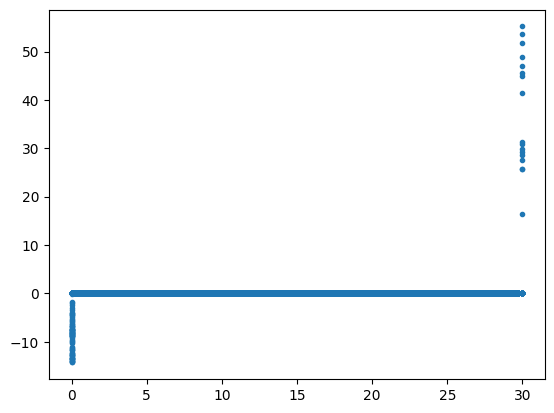

In [5]:
plt.plot(data["x"], data["F3"],".")

In [6]:
F3 = data["F3"][data["x"]< data["x"].mean()]
P = -4*F3.sum()
B = 25
L = 60
tn  = 2.934
tl = 0.475
t = tn + 4*tl
U = 5

In [7]:

Eflex = (P*L**3)/(4*U*B*t**3) * 1e-3

In [8]:
print("Eflex = ", Eflex)

Eflex =  9.685226250292773


In [9]:
import numpy as np

In [10]:
import numpy as np
# cilindro
Ly = 25
Lx = 60
tn  = 2.934
tl = 0.475
r  = 3*tl/8
d_Y  = 0.74297
d_X  = 0.55872

A = np.pi*r**2



R = 10/6
nx_fibres = 3


z0 = tn/2
dx = 0.1 
dz = 0.1


hx = R
hz = tl
Lz = 2*2*hz + 2*z0 

yspan = np.arange(0, Ly/2 - hx, hx)
yspan = yspan + hx/2

xspan = hx/2 + hx*np.arange(0, nx_fibres, 1)

FP1_list = []
FM1_list = []
FP2_list = []
FM2_list = []

trajs_Y = []
for iy in yspan:
    
    # x in [ 0, nx_fibres*hx]
    xspan_loop = np.linspace(0, nx_fibres*hx, 50)
    yspan_loop = np.zeros_like(xspan_loop) + iy
    zspan_loop = np.zeros_like(xspan_loop) - z0 - hz/2
    itraj = np.array([xspan_loop, yspan_loop, zspan_loop]).T
    trajs_Y.append(itraj)

trajs_X = []

for ix in xspan:
    # x in [ 0, nx_fibres*hx]
    yspan_loop = np.linspace(0,Ly/2, 50)
    xspan_loop = np.zeros_like(yspan_loop) + ix

    zspan_loop = np.zeros_like(xspan_loop) - z0 - hz/2
    itraj = np.array([xspan_loop, yspan_loop, zspan_loop]).T
    trajs_X.append(itraj)
    

In [11]:
from matplotlib import pyplot as plt

C:\Users\djoroya\AppData\Local\Temp\ipykernel_24096\4252513939.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  plt.scatter(itraj[1:,0],


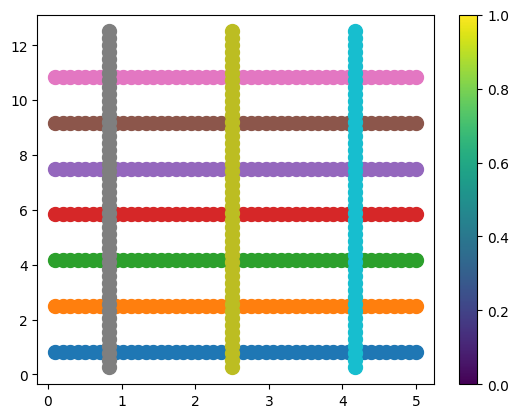

In [12]:
for itraj in [*trajs_Y, *trajs_X]:
    plt.scatter(itraj[1:,0],
                itraj[1:,1], s=100, cmap='viridis',vmax=1000,vmin=0)
    
plt.colorbar()

In [13]:
from scipy.interpolate import NearestNDInterpolator
from gmshtools.grid_section import grid_section


def compute_P1_max(data,idesign,d):

    x = data["x"]
    y = data["y"]
    z = data["z"]
    P1 = data["P1"]

    fcn = NearestNDInterpolator((x,y,z),P1)


    P1_mu_list = []
    P1_all = []
    for jj,jtrajs in enumerate(idesign):

        jtraj_diff = np.diff(jtrajs,axis=0)
        P1_mu_list_by = []
        for j in range(0,len(jtraj_diff),1):

            vec_z =  jtraj_diff[j]
            vec_z = vec_z/np.linalg.norm(vec_z)
            vec_x = np.cross(vec_z, [0,0,1])
            vec_x = vec_x/np.linalg.norm(vec_x)

            X,Y,Z = grid_section(jtrajs[j][0],
                                jtrajs[j][1],
                                jtrajs[j][2],
                                vec_z,
                                vec_x,
                                0.8*d,
                                0.8*r,
                                rho=150)
            P1 = fcn(X,Y,Z)
            P1_mu = np.mean(P1)
            P1_mu_list_by.append(P1_mu)
            P1_mu_list.append(P1_mu)

        # ============================
        P1_all.append(np.array(P1_mu_list_by))
        # ============================
    P1_max = np.max(P1_mu_list)
    P1_all = np.array(P1_all)
    return P1_max,P1_all

In [14]:
P1_max_Y,P1_all_Y = compute_P1_max(ifrd["data_blocks"][0],trajs_Y, d_Y)
P1_max_X,P1_all_X = compute_P1_max(ifrd["data_blocks"][0],trajs_X, d_X)


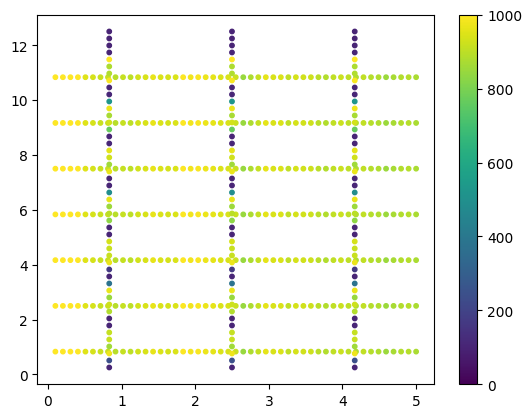

In [15]:
for itraj in trajs_Y:
    plt.scatter(itraj[1:,0],
                itraj[1:,1], c= P1_all_Y[0], s=10, cmap='viridis',vmax=1000,vmin=0)
    
for itraj in trajs_X:
    plt.scatter(itraj[1:,0],
                itraj[1:,1], c= P1_all_X[0], s=10, cmap='viridis',vmax=1000,vmin=0)
plt.colorbar()

In [16]:
from loadsavejson.savejson import savejson

C:\Users\djoroya\AppData\Local\Temp\ipykernel_24096\774545637.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  plt.scatter(data_cp["z"],data_cp["y"], s=0.1, cmap='viridis',vmax=1000,vmin=0)


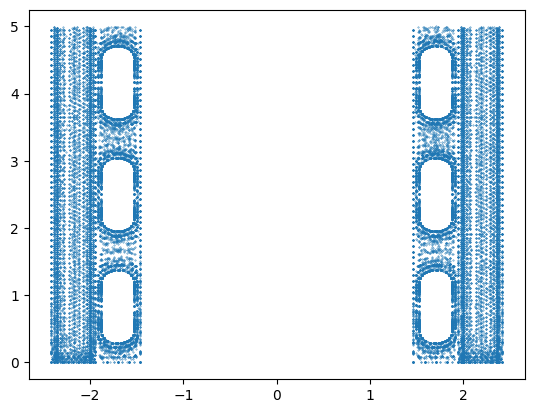

In [17]:
from djccx.inp.inp import inp

inp_f = inp("output/main.inp")
ifrd = readfrd("output/main.frd")
RESINA = inp_f.select("RESINA","elset")
df = RESINA.GetUniqueNodes(inp_f)
indx_frd = df.index.values

nodes_matrix = ifrd["data_blocks"][0].loc[indx_frd]
data_cp = nodes_matrix.copy()
data_cp = data_cp[(data_cp["x"] > -2.5) & (data_cp["x"] < 2.5)]
# y in -5, 5
data_cp = data_cp[(data_cp["y"] > -5) & (data_cp["y"] < 5)]
id_max = np.argmax(data_cp["P1"])

P1_max = data_cp["P1"].iloc[id_max]
x_max = data_cp["x"].iloc[id_max]
y_max = data_cp["y"].iloc[id_max]
z_max = data_cp["z"].iloc[id_max]

dist = np.sqrt((x_max - nodes_matrix["x"])**2 + \
                (y_max - nodes_matrix["y"])**2 + \
                (z_max - nodes_matrix["z"])**2)
        
nodes_matrix = nodes_matrix[dist < 0.05]
P1_max_resina = np.mean(nodes_matrix["P1"])
P1_max_resina = P1_max 
# plot xz view scatter 
plt.scatter(data_cp["z"],data_cp["y"], s=0.1, cmap='viridis',vmax=1000,vmin=0)
# ratio 


In [18]:
P1_max_resina

np.float64(1108.3313088267448)

In [19]:
P1_max_X

np.float64(997.4934731053236)

In [20]:
savejson({
    "P1_max_Y": P1_max_Y.tolist(),
    "P1_max_X": P1_max_X.tolist(),
    "P1_all_Y": P1_all_Y.tolist(),
    "P1_all_X": P1_all_X.tolist(),
    "Eflex": Eflex,
    "P1_max" : np.max([P1_max_Y,P1_max_X]),
    "P1_max_resina": P1_max_resina,
    "position": [x_max,y_max,z_max],
},"P1.json")